# Nitrogen thresholds into Acidification Potential Thresholds
This translates each ecoreigon threshold into an acidification potential threshold. It divides total nitrogen deposition into NH3 and NOx, calculate average for each ecoregion, and divides the threshold according to that average. It then apply each LEAF into it and voila

## Nitrogen breakdown

In [164]:
import polars as pl
import geopandas as gpd
import pandas as pd
import sbtn_leaf.map_plotting as mplot
import sbtn_leaf.map_calculations as mc
from rasterio.warp import Resampling

Select needed files for 2020


In [2]:
tot_NOy_fp = "../thresholds/Global_N_deposition_grid_dataset_2008_2020/mean_totNOy_2020_hm.tif"
tot_NHx_fp = "../thresholds/Global_N_deposition_grid_dataset_2008_2020/mean_totNHx_2020_hm.tif"
tot_N_fp   = "../thresholds/Global_N_deposition_grid_dataset_2008_2020/mean_totN_2020_hm.tif"

Checking total N depositions

In [3]:
mplot.inspect_raster(tot_N_fp)

File: ../thresholds/Global_N_deposition_grid_dataset_2008_2020/mean_totN_2020_hm.tif
Driver: GTiff
Width, Height: 2307, 1430
Number of Bands: 1
CRS: PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",105],PARAMETER["standard_parallel_1",25],PARAMETER["standard_parallel_2",47],PARAMETER["false_easting",4000000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Bounds: BoundingBox(left=-12754690.136988254, bottom=-4121276.274192298, right=20764251.306624927, top=16655527.481493374)
Pixel Size: (14529.233395584386, 14529.233395584386)
No-data Value: -3.4028234663852886e+38

--- Raster Metadata ---
DataType: Generic
AREA

Raster has 475,006 unique values. Min: 0.00. Max: 67.28
Using quantiles
All positives route (quantiles)


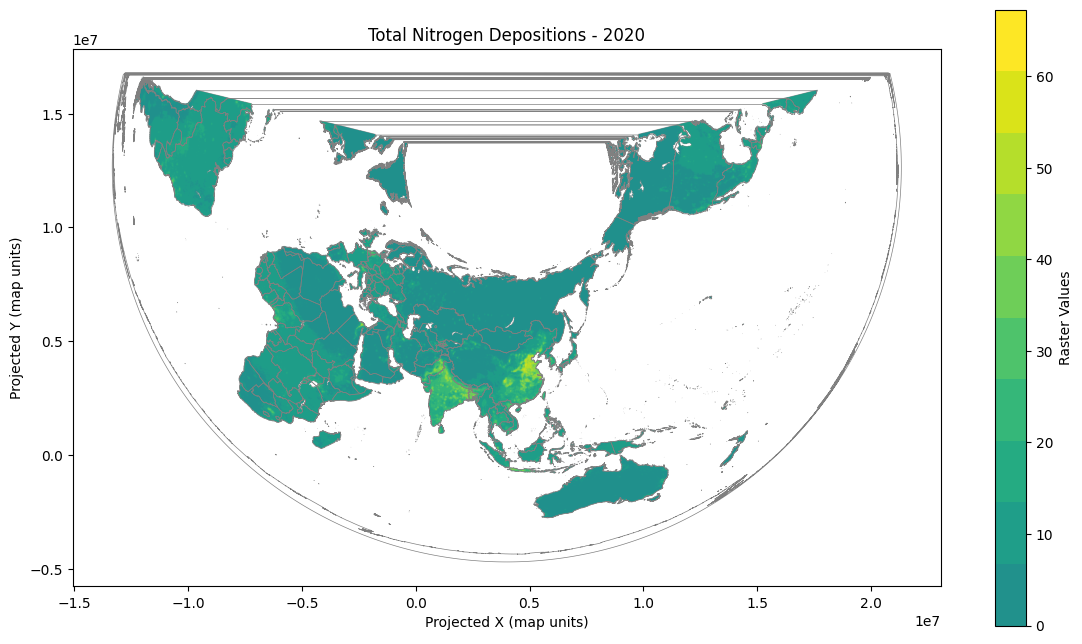

In [4]:
mplot.plot_raster_on_world_extremes_cutoff(tot_N_fp, "Total Nitrogen Depositions - 2020", perc_cutoff=0, quantiles=10)

Creating a 10-year average

In [5]:
import numpy as np
import rasterio

def decade_mean(prefix: str, years=range(2011, 2021)):
    paths = [
        f"../thresholds/Global_N_deposition_grid_dataset_2008_2020/{prefix}_{yr}_hm.tif"
        for yr in years
    ]
    with rasterio.open(paths[0]) as src0:
        meta = src0.meta.copy()
        sum_arr = np.zeros(src0.shape, dtype="float64")
        count = np.zeros(src0.shape, dtype="int16")
        nodata = src0.nodata

    for fp in paths:
        with rasterio.open(fp) as src:
            arr = src.read(1)
            mask = arr != nodata
            sum_arr[mask] += arr[mask]
            count[mask] += 1

    mean_arr = np.divide(sum_arr, count, out=np.zeros_like(sum_arr), where=count > 0)
    nodata_value = nodata if nodata is not None else np.nan
    mean_arr[count == 0] = nodata_value
    meta.update(dtype="float32", nodata=nodata)

    out_fp = f"../thresholds/{prefix}_2011_2020_mean.tif"
    
    with rasterio.open(out_fp, "w", **meta) as dst:
        dst.write(mean_arr.astype("float32"), 1)
    return out_fp

In [6]:
# Build averaged rasters
tot_N_fp = decade_mean("mean_totN")
tot_NHx_fp = decade_mean("mean_totNHx")
tot_NOy_fp = decade_mean("mean_totNOy")

Harmonizing into UHTHs

In [82]:
uhth_fp = "../data/world_maps/soc_uht_map.tif"
tot_N_uhth_fp = "../thresholds/totN_2011_2020_mean_uhth.tif"
tot_NHx_uhth_fp = "../thresholds/totNHx_2011_2020_mean_uhth.tif"
tot_NOy_uhth_fp = "../thresholds/totNOy_2011_2020_mean_uhth.tif"

In [88]:
mc.resample_raster_to_match(
    src_path=tot_N_fp,
    target_path=uhth_fp,
    output_path=tot_N_uhth_fp,
    resampling_method=Resampling.average
)

In [89]:
mc.resample_raster_to_match(
    src_path=tot_NHx_fp,
    target_path=uhth_fp,
    output_path=tot_NHx_uhth_fp,
    resampling_method=Resampling.average
)

In [90]:
mc.resample_raster_to_match(
    src_path=tot_NOy_fp,
    target_path=uhth_fp,
    output_path=tot_NOy_uhth_fp,
    resampling_method=Resampling.average
)

Inpsecting

In [91]:
mplot.inspect_raster(tot_N_uhth_fp)

File: ../thresholds/totN_2011_2020_mean_uhth.tif
Driver: GTiff
Width, Height: 4320, 2083
Number of Bands: 1
CRS: EPSG:4326
Bounds: BoundingBox(left=-179.99999999999997, bottom=-89.99999999999994, right=179.99999999999991, top=83.58333333333331)
Pixel Size: (0.0833333333333333, 0.0833333333333333)
No-data Value: -3.4028234663852886e+38

--- Raster Metadata ---
AREA_OR_POINT: Area

--- Band Information ---

Band 1:
  Data Type: float32
  Min Value: 0.0
  Max Value: 66.80951690673828
  Mean Value: 5.940975189208984
  Standard Deviation: 6.362316131591797


Raster has 1,944,581 unique values. Min: 0.00. Max: 66.81
Using quantiles
All positives route (quantiles)


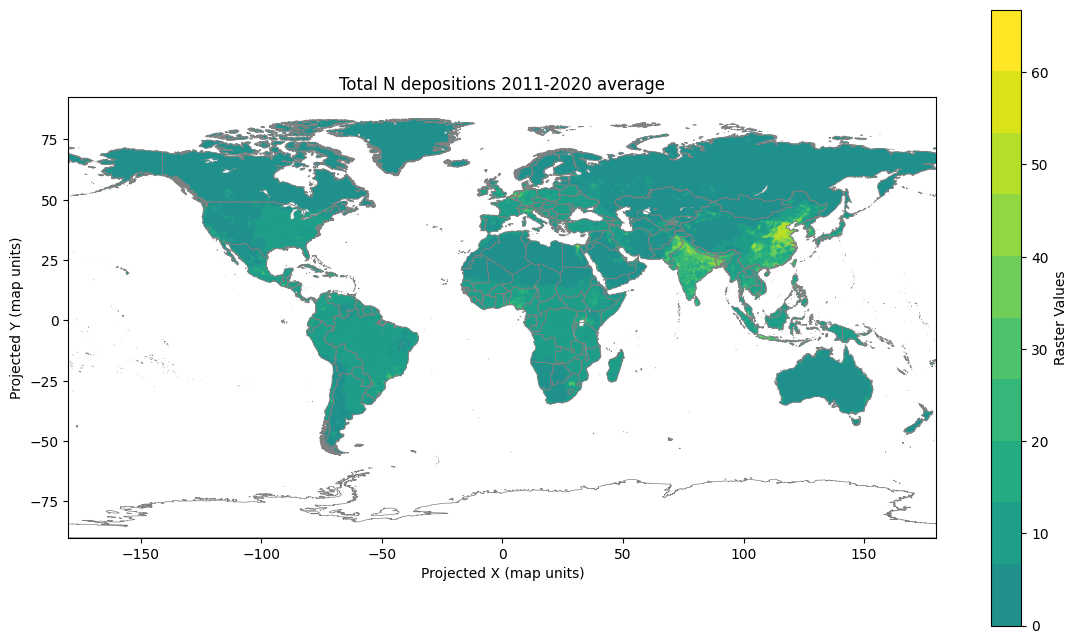

In [92]:
mplot.plot_raster_on_world_extremes_cutoff(tot_N_uhth_fp, "Total N depositions 2011-2020 average", perc_cutoff=0, quantiles=10)

Transforming

In [93]:
tot_N_er_results = mc.calculate_area_weighted_cfs_from_raster_with_std_and_median_vOutliers(
    raster_input_filepath=tot_N_uhth_fp,
    cf_name="N depositions",
    cf_unit="kg N/ha",
    flow_name="tot_N",
    area_type="ecoregion"
)

2025-11-18 13:46:40,327 - INFO - Starting: Calculating ecoregion weighted CF for tot_N without outlier filtering
2025-11-18 13:50:45,866 - INFO - Calculations complete for ../thresholds/totN_2011_2020_mean_uhth.tif! Found matches for 781 regions.



In [94]:
tot_NHx_er_results = mc.calculate_area_weighted_cfs_from_raster_with_std_and_median_vOutliers(
    raster_input_filepath=tot_NHx_uhth_fp,
    cf_name="N depositions",
    cf_unit="kg N/ha",
    flow_name="tot_NHx",
    area_type="ecoregion"
)

2025-11-18 13:50:45,893 - INFO - Starting: Calculating ecoregion weighted CF for tot_NHx without outlier filtering
2025-11-18 13:54:44,626 - INFO - Calculations complete for ../thresholds/totNHx_2011_2020_mean_uhth.tif! Found matches for 781 regions.



In [95]:
tot_NOy_er_results = mc.calculate_area_weighted_cfs_from_raster_with_std_and_median_vOutliers(
    raster_input_filepath=tot_NOy_uhth_fp,
    cf_name="N depositions",
    cf_unit="kg N/ha",
    flow_name="tot_NOy",
    area_type="ecoregion"
)

2025-11-18 13:54:44,764 - INFO - Starting: Calculating ecoregion weighted CF for tot_NOy without outlier filtering
2025-11-18 13:58:18,045 - INFO - Calculations complete for ../thresholds/totNOy_2011_2020_mean_uhth.tif! Found matches for 781 regions.



In [96]:
tot_N_er_gdf = tot_N_er_results[1]
tot_NHx_er_gdf = tot_NHx_er_results[1]
tot_NOy_er_gdf = tot_NOy_er_results[1]

<Axes: >

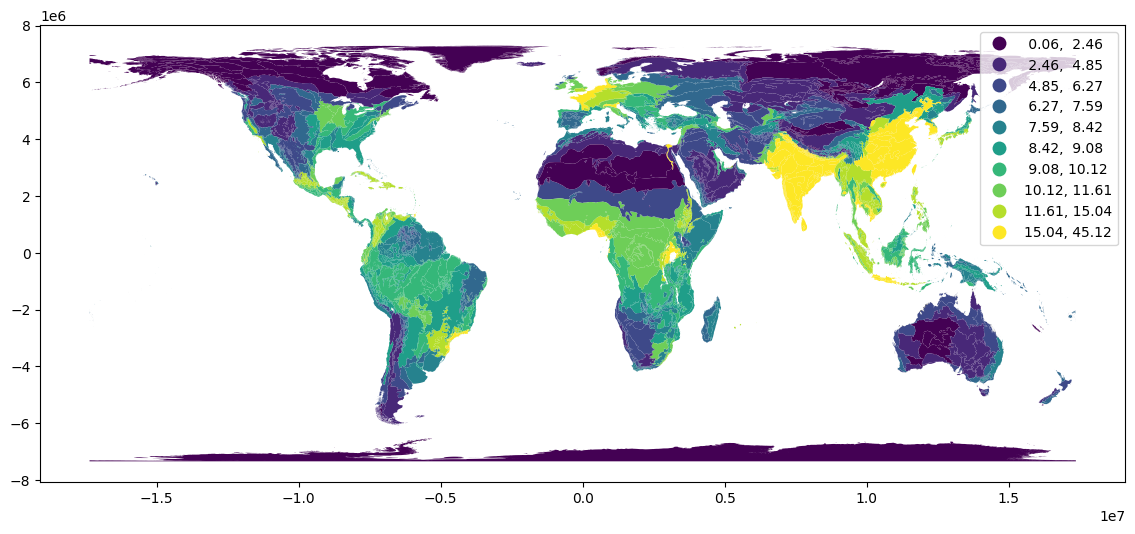

In [97]:
tot_N_er_gdf.plot(column = "cf", figsize = (14,8), legend = True, scheme = "Quantiles", k = 10)

Which looks ok. Now massaging the gdf to merge them

In [98]:
tot_N_er_gdf

,OBJECTID,ECO_NAME,BIOME_NUM,BIOME_NAME,REALM,ECO_BIOME_,ECO_ID,geometry,er_id,er_name,Biome,imp_cat,flow_name,unit,cf,cf_median,cf_std
0,1.0,Adelie Land tundra,11.0,Tundra,Antarctica,AN11,117,"MULTIPOLYGON (((15313733.007 -6878278.25, 1531...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,Admiralty Islands lowland rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,135,"MULTIPOLYGON (((14211289.839 -328506.485, 1420...",135.0,Admiralty Islands lowland rain forests,Tropical & Subtropical Moist Broadleaf Forests,N depositions,tot_N,kg N/ha,8.074792,7.820885,0.555437
2,3.0,Aegean and Western Turkey sclerophyllous and m...,12.0,"Mediterranean Forests, Woodlands & Scrub",Palearctic,PA12,785,"MULTIPOLYGON (((2594187.496 4232365.534, 25938...",785.0,Aegean and Western Turkey sclerophyllous and m...,"Mediterranean Forests, Woodlands & Scrub",N depositions,tot_N,kg N/ha,8.574942,7.676392,2.483052
3,4.0,Afghan Mountains semi-desert,13.0,Deserts & Xeric Shrublands,Palearctic,PA13,807,"MULTIPOLYGON (((6318553.57 4168604.183, 632262...",807.0,Afghan Mountains semi-desert,Deserts & Xeric Shrublands,N depositions,tot_N,kg N/ha,5.081014,5.320418,1.062485
4,5.0,Ahklun and Kilbuck Upland Tundra,11.0,Tundra,Nearctic,NE11,404,"MULTIPOLYGON (((-15463281.201 6262077.155, -15...",404.0,Ahklun and Kilbuck Upland Tundra,Tundra,N depositions,tot_N,kg N/ha,0.551416,0.378810,0.582124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,848.0,Sulawesi lowland rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,156,"MULTIPOLYGON (((11320842.132 -958323.804, 1131...",156.0,Sulawesi lowland rain forests,Tropical & Subtropical Moist Broadleaf Forests,N depositions,tot_N,kg N/ha,9.373842,8.466715,3.004624
843,212.0,East African montane forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Afrotropic,AF01,8,"MULTIPOLYGON (((3544664.721 -399111.126, 35446...",8.0,East African montane forests,Tropical & Subtropical Moist Broadleaf Forests,N depositions,tot_N,kg N/ha,14.414590,14.376391,4.932253
844,224.0,Eastern Arc forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Afrotropic,AF01,9,"MULTIPOLYGON (((3510170.876 -1139262.003, 3510...",9.0,Eastern Arc forests,Tropical & Subtropical Moist Broadleaf Forests,N depositions,tot_N,kg N/ha,9.292855,9.297496,0.928106
845,79.0,Borneo montane rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Indomalayan,IN01,220,"MULTIPOLYGON (((10885961.971 -64628.237, 10885...",220.0,Borneo montane rain forests,Tropical & Subtropical Moist Broadleaf Forests,N depositions,tot_N,kg N/ha,8.758571,8.665158,1.283255


In [99]:
tot_N_er_gdf = tot_N_er_gdf.drop(columns=["er_id","er_name", "Biome", "flow_name", ])
tot_NHx_er_gdf = tot_NHx_er_gdf.drop(columns=["er_id","er_name", "Biome", "imp_cat", "flow_name", "unit"])
tot_NOy_er_gdf = tot_NOy_er_gdf.drop(columns=["er_id","er_name", "Biome", "imp_cat", "flow_name", "unit"])

In [100]:
tot_N_er_gdf = tot_N_er_gdf.rename(columns={
    "cf": "N_avg",
    "cf_median": "N_med",
    "cf_std": "N_std",
})

tot_NHx_er_gdf = tot_NHx_er_gdf.rename(columns={
    "cf": "NHx_avg",
    "cf_median": "NHx_med",
    "cf_std": "NHx_std",
})

tot_NOy_er_gdf = tot_NOy_er_gdf.rename(columns={
    "cf": "NOy_avg",
    "cf_median": "NOy_med",
    "cf_std": "NOy_std",
})

In [101]:
drop_columns = ["ECO_NAME",	"BIOME_NUM", "BIOME_NAME", "REALM",	"ECO_BIOME_", "OBJECTID", "geometry"]

In [102]:
all_N_er_gdf = tot_N_er_gdf.merge(
    tot_NHx_er_gdf.drop(columns=drop_columns),
    on = "ECO_ID",
    how = "left"
).merge(
    tot_NOy_er_gdf.drop(columns=drop_columns),
    on = "ECO_ID",
    how = "left"
)

Now calculating the NHx and NOy breakdown

In [103]:
all_N_er_gdf['NHx_perc'] = all_N_er_gdf.apply(
    lambda row: row['NHx_avg'] / row['N_avg'] if row['N_avg'] != 0 else None,
    axis=1
)

all_N_er_gdf['NOy_perc'] = all_N_er_gdf.apply(
    lambda row: row['NOy_avg'] / row['N_avg'] if row['N_avg'] != 0 else None,
    axis=1
)

all_N_er_gdf['N_perc_check'] = all_N_er_gdf.apply(
    lambda row: round(row['NHx_perc'] + row['NOy_perc'],2) if row['NOy_perc'] != 0 else None,
    axis=1
)

Checking all values add up to 100%

In [104]:
all_N_er_gdf[(all_N_er_gdf["N_perc_check"] != 1.0) & (all_N_er_gdf["N_perc_check"].notna())].shape[0]

0

Which they do.

Quickly plotting percentage of NHx emissions...

<Axes: >

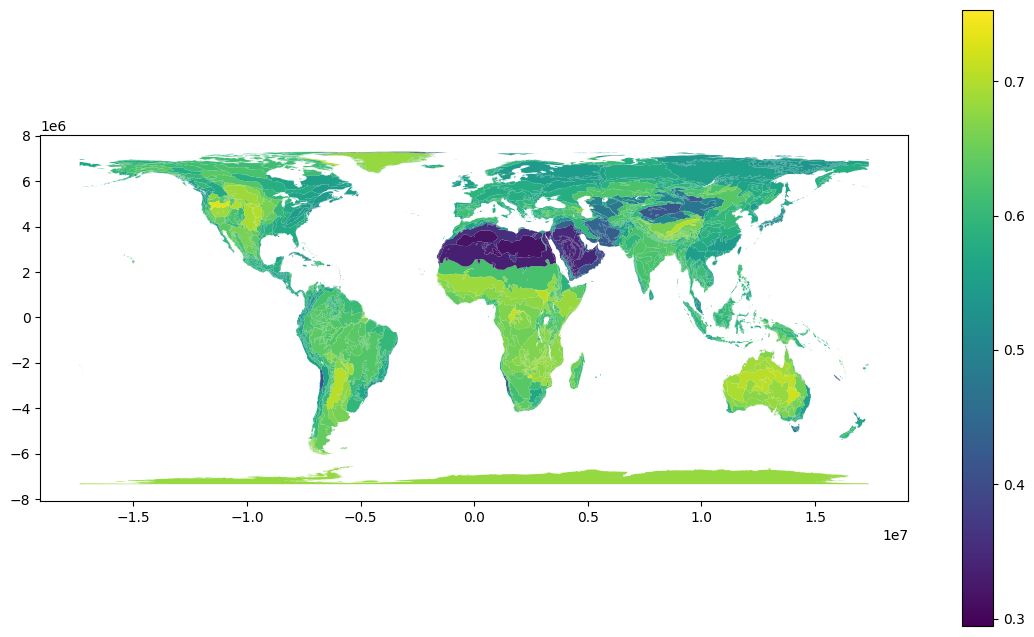

In [105]:
all_N_er_gdf.plot(column="NHx_perc", legend = True, figsize = (14,8))

## Nitrogen Thresholds import

Loading the thresholds

In [106]:
N_thresholds = pl.read_csv("../thresholds/acid_thresholds.csv")

Checking the file

In [107]:
N_thresholds.head(5)

ECO ID,Ecoregion name,Threshold,Ecoregion baseline,Target (10% above threshold),Threshold exceedance,Difference between baseline and target,Threshold met or exceeded? (Y/N)
i64,str,f64,str,f64,str,str,str
1,"""Albertine Rift montane forests""",20.0,"""13.8""",18.0,"""-6.2""","""-4.2""","""No"""
2,"""Cameroon Highlands forests""",20.0,"""16.5""",18.0,"""-3.5""","""-1.5""","""No"""
3,"""Central Congolian lowland fore…",14.2,"""14.1""",12.78,"""-0.1""","""1.32""","""No"""
4,"""Comoros forests""",20.0,"""2.2""",18.0,"""-17.8""","""-15.8""","""No"""
5,"""Congolian coastal forests""",9.8,"""11.9""",8.82,"""2.1""","""3.08""","""Yes"""


Selecting needed columns and merging them into the gdf

In [108]:
N_thresholds = N_thresholds["ECO ID", "Threshold", "Ecoregion baseline"]

In [109]:
N_thresholds_breakdown_gdf = all_N_er_gdf.merge(N_thresholds.to_pandas(), how="left", left_on="ECO_ID", right_on="ECO ID")

Now filtering out the ones without thresholds

In [110]:
N_thresholds_breakdown_gdf = N_thresholds_breakdown_gdf[N_thresholds_breakdown_gdf["Threshold"].notna()]

Dividing the threshold into NHx and NOy

In [111]:
N_thresholds_breakdown_gdf["NHx_th"] = N_thresholds_breakdown_gdf["NHx_perc"] * N_thresholds_breakdown_gdf["Threshold"]
N_thresholds_breakdown_gdf["NOy_th"] = N_thresholds_breakdown_gdf["NOy_perc"] * N_thresholds_breakdown_gdf["Threshold"]

In [112]:
N_thresholds_breakdown_gdf=N_thresholds_breakdown_gdf.drop(columns=["ECO ID", "N_perc_check"])

In [113]:
N_thresholds_breakdown_gdf.head()

,OBJECTID,ECO_NAME,BIOME_NUM,BIOME_NAME,REALM,ECO_BIOME_,ECO_ID,geometry,imp_cat,unit,...,NHx_std,NOy_avg,NOy_med,NOy_std,NHx_perc,NOy_perc,Threshold,Ecoregion baseline,NHx_th,NOy_th
1,2.0,Admiralty Islands lowland rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,135,"MULTIPOLYGON (((14211289.839 -328506.485, 1420...",N depositions,kg N/ha,...,0.194545,3.308104,3.137780,0.523925,0.590317,0.409683,20.0,1.2,11.806342,8.193658
2,3.0,Aegean and Western Turkey sclerophyllous and m...,12.0,"Mediterranean Forests, Woodlands & Scrub",Palearctic,PA12,785,"MULTIPOLYGON (((2594187.496 4232365.534, 25938...",N depositions,kg N/ha,...,1.421858,3.553697,3.204433,1.120015,0.585572,0.414428,7.5,10,4.391790,3.108210
3,4.0,Afghan Mountains semi-desert,13.0,Deserts & Xeric Shrublands,Palearctic,PA13,807,"MULTIPOLYGON (((6318553.57 4168604.183, 632262...",N depositions,kg N/ha,...,0.865046,2.033892,2.015274,0.386762,0.599708,0.400292,1.6,1.8,0.959532,0.640468
4,5.0,Ahklun and Kilbuck Upland Tundra,11.0,Tundra,Nearctic,NE11,404,"MULTIPOLYGON (((-15463281.201 6262077.155, -15...",N depositions,kg N/ha,...,0.345060,0.232328,0.163158,0.238495,0.578671,0.421329,10.0,0.4,5.786706,4.213294
5,6.0,Al-Hajar foothill xeric woodlands and shrublands,8.0,"Temperate Grasslands, Savannas & Shrublands",Palearctic,PA08,722,"MULTIPOLYGON (((5434650.418 3116933.305, 54346...",N depositions,kg N/ha,...,1.201166,4.401758,4.018368,1.179634,0.386031,0.613969,15.0,4.7,5.790461,9.209539


Which looks ok.

## Applying LEAFs

Now loading the leafs...

In [114]:
acid_leafs = pl.read_csv("../LEAFs/acidification/soil_erosion_ecoregion.csv")

In [115]:
acid_leafs.head()

ECO_ID,er_id,value,metric,flow_name,ECO_NAME,BIOME_NUM,BIOME_NAME,REALM
i64,f64,f64,str,str,str,f64,str,str
117,117.0,0.0,"""cf_mean""","""nh3""","""Adelie Land tundra""",11.0,"""Tundra""","""Antarctica"""
135,135.0,0.083384,"""cf_mean""","""nh3""","""Admiralty Islands lowland rain…",1.0,"""Tropical & Subtropical Moist B…","""Australasia"""
785,785.0,1.339552,"""cf_mean""","""nh3""","""Aegean and Western Turkey scle…",12.0,"""Mediterranean Forests, Woodlan…","""Palearctic"""
807,807.0,4.597294,"""cf_mean""","""nh3""","""Afghan Mountains semi-desert""",13.0,"""Deserts & Xeric Shrublands""","""Palearctic"""
404,404.0,1.315695,"""cf_mean""","""nh3""","""Ahklun and Kilbuck Upland Tund…",11.0,"""Tundra""","""Nearctic"""


Selecting the needed columns

In [116]:
acid_leafs = acid_leafs["ECO_ID", "value", "metric", "flow_name"]

Filtering the metric...

In [117]:
acid_leafs = acid_leafs.filter(pl.col("metric")=="cf_mean").drop("metric")

In [118]:
acid_leafs.head()

ECO_ID,value,flow_name
i64,f64,str
117,0.0,"""nh3"""
135,0.083384,"""nh3"""
785,1.339552,"""nh3"""
807,4.597294,"""nh3"""
404,1.315695,"""nh3"""


Now pivoting the table

In [119]:
acid_leafs_wide = acid_leafs.pivot(
    on="flow_name",
    index="ECO_ID",
    values="value"
)

Checking...

In [120]:
acid_leafs_wide.head()

ECO_ID,nh3,nox,so2
i64,f64,f64,f64
117,0.0,0.0,0.032829
135,0.083384,0.017149,0.12358
785,1.339552,0.440806,0.702696
807,4.597294,1.096361,3.073882
404,1.315695,0.352516,2.490474


Renaming the columns and merging

In [121]:
acid_leafs_wide = acid_leafs_wide.rename({
    "nh3": "leaf_nh3",
    "nox": "leaf_nox",
    "so2": "leaf_so2"
}).to_pandas()

In [122]:
N_th_leaf_gdf = N_thresholds_breakdown_gdf.merge(acid_leafs_wide, on="ECO_ID")

In [123]:
N_th_leaf_gdf.head()

,OBJECTID,ECO_NAME,BIOME_NUM,BIOME_NAME,REALM,ECO_BIOME_,ECO_ID,geometry,imp_cat,unit,...,NOy_std,NHx_perc,NOy_perc,Threshold,Ecoregion baseline,NHx_th,NOy_th,leaf_nh3,leaf_nox,leaf_so2
0,2.0,Admiralty Islands lowland rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,135,"MULTIPOLYGON (((14211289.839 -328506.485, 1420...",N depositions,kg N/ha,...,0.523925,0.590317,0.409683,20.0,1.2,11.806342,8.193658,0.083384,0.017149,0.123580
1,3.0,Aegean and Western Turkey sclerophyllous and m...,12.0,"Mediterranean Forests, Woodlands & Scrub",Palearctic,PA12,785,"MULTIPOLYGON (((2594187.496 4232365.534, 25938...",N depositions,kg N/ha,...,1.120015,0.585572,0.414428,7.5,10,4.391790,3.108210,1.339552,0.440806,0.702696
2,4.0,Afghan Mountains semi-desert,13.0,Deserts & Xeric Shrublands,Palearctic,PA13,807,"MULTIPOLYGON (((6318553.57 4168604.183, 632262...",N depositions,kg N/ha,...,0.386762,0.599708,0.400292,1.6,1.8,0.959532,0.640468,4.597294,1.096361,3.073882
3,5.0,Ahklun and Kilbuck Upland Tundra,11.0,Tundra,Nearctic,NE11,404,"MULTIPOLYGON (((-15463281.201 6262077.155, -15...",N depositions,kg N/ha,...,0.238495,0.578671,0.421329,10.0,0.4,5.786706,4.213294,1.315695,0.352516,2.490474
4,6.0,Al-Hajar foothill xeric woodlands and shrublands,8.0,"Temperate Grasslands, Savannas & Shrublands",Palearctic,PA08,722,"MULTIPOLYGON (((5434650.418 3116933.305, 54346...",N depositions,kg N/ha,...,1.179634,0.386031,0.613969,15.0,4.7,5.790461,9.209539,1.765440,0.406826,0.719897


Factors to transform kg N to kg NH3 and kg NO2

In [124]:
n2nh3 = 17/14
n2no2 = (14+2*16)/14

Finally calculating the SO2 equivalent tresholds

In [125]:
SO2_eq_th = N_th_leaf_gdf[N_th_leaf_gdf["Ecoregion baseline"] != "NA"].copy()

SO2_eq_th["Ecoregion baseline"] = SO2_eq_th["Ecoregion baseline"].astype("float32")

# Thresholds
SO2_eq_th["NHx_th_so2"] = SO2_eq_th["NHx_th"] *  SO2_eq_th["leaf_nh3"] * n2nh3
SO2_eq_th["NOy_th_so2"] = SO2_eq_th["NOy_th"] *  SO2_eq_th["leaf_nox"] * n2no2
SO2_eq_th["N_th_so2"] = SO2_eq_th["NHx_th_so2"] + SO2_eq_th["NOy_th_so2"]

# Baselines
SO2_eq_th["er_base_NHx"] = SO2_eq_th["Ecoregion baseline"] *  SO2_eq_th["NHx_perc"]
SO2_eq_th["er_base_NOy"] = SO2_eq_th["Ecoregion baseline"] *  SO2_eq_th["NOy_perc"]

# Converted Baselines
SO2_eq_th["er_base_NHx_so2"] = SO2_eq_th["er_base_NHx"] *  SO2_eq_th["leaf_nh3"] * n2nh3
SO2_eq_th["er_base_NOy_so2"] = SO2_eq_th["er_base_NOy"] *  SO2_eq_th["leaf_nox"] * n2no2
SO2_eq_th["er_base_N_so2"] = SO2_eq_th["er_base_NHx_so2"] + SO2_eq_th["er_base_NOy_so2"]

# Calculating percentages over target
SO2_eq_th["TB_distance"] = (SO2_eq_th["Threshold"]*0.9 - SO2_eq_th["Ecoregion baseline"])/SO2_eq_th["Ecoregion baseline"]
SO2_eq_th["TB_distance_SO2"] = (SO2_eq_th["N_th_so2"]*0.9 - SO2_eq_th["er_base_N_so2"] )/SO2_eq_th["er_base_N_so2"] 
SO2_eq_th["TBD_ratio"] = SO2_eq_th["TB_distance"]/SO2_eq_th["TB_distance_SO2"]


### Checking results

Targets

<Axes: >

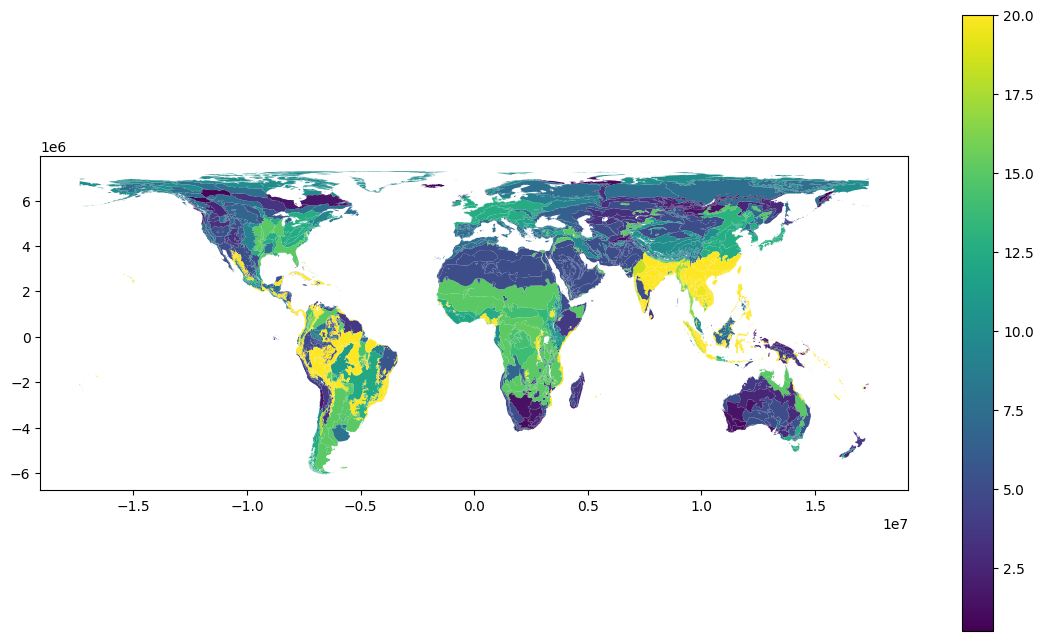

In [126]:
SO2_eq_th.plot(column="Threshold", legend = True, figsize = (14,8))

<Axes: >

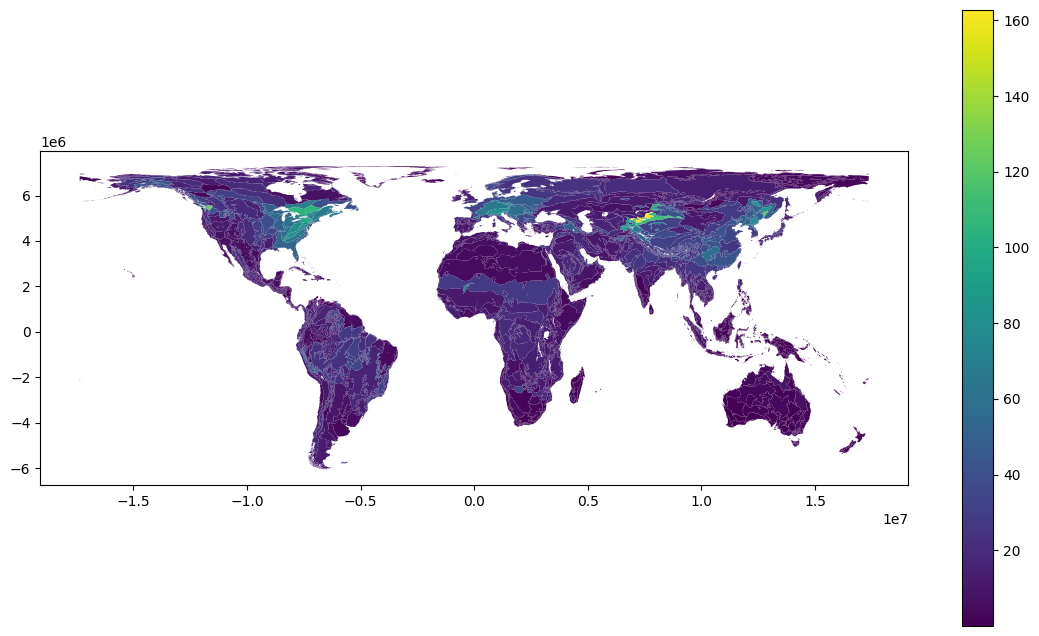

In [127]:
SO2_eq_th.plot(column="N_th_so2", legend = True, figsize = (14,8))

It can be seen that targets change, as the LEAFs can have significantly different values. This could mean that we keep treating, up to target setting, targets in their original form

#### Distance to Target Normalized
As targets are relative to their own ecoregion, it's important to keep the baseline distance to target, normalized, equal, so the same ecoregions lead to the same conclusions. This should happen as the same linear transformation is being applied to both target and baseline, but it should be checked nevertheless.

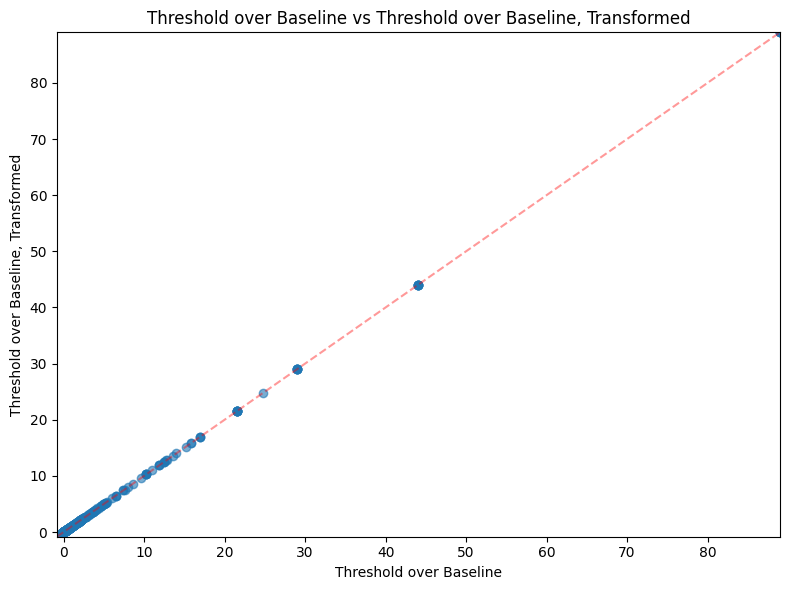

In [128]:
import numpy as np
import matplotlib.pyplot as plt

# Keep only finite pairs (no NaN, no Inf)
mask = np.isfinite(SO2_eq_th["TB_distance"]) & np.isfinite(SO2_eq_th["TB_distance_SO2"])
x = SO2_eq_th.loc[mask, "TB_distance"]
y = SO2_eq_th.loc[mask, "TB_distance_SO2"]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6)

plt.xlabel("Threshold over Baseline")
plt.ylabel("Threshold over Baseline, Transformed")
plt.title("Threshold over Baseline vs Threshold over Baseline, Transformed")

# Compute clean limits
lims = [min(x.min(), y.min()), max(x.max(), y.max())]

# 1:1 line
plt.plot(lims, lims, color="red", linewidth=1.5, alpha=0.4, linestyle='--')

plt.xlim(lims)
plt.ylim(lims)

plt.tight_layout()
plt.show()


Which shows there's a 1:1 relationship.

Plotting the maps

c:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\.venv\Lib\site-packages\mapclassify\classifiers.py:942: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
c:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\.venv\Lib\site-packages\mapclassify\classifiers.py:972: RuntimeWarning: invalid value encountered in scalar divide
  gadf = 1 if adam == 0 else 1 - self.adcm / adam


<Axes: >

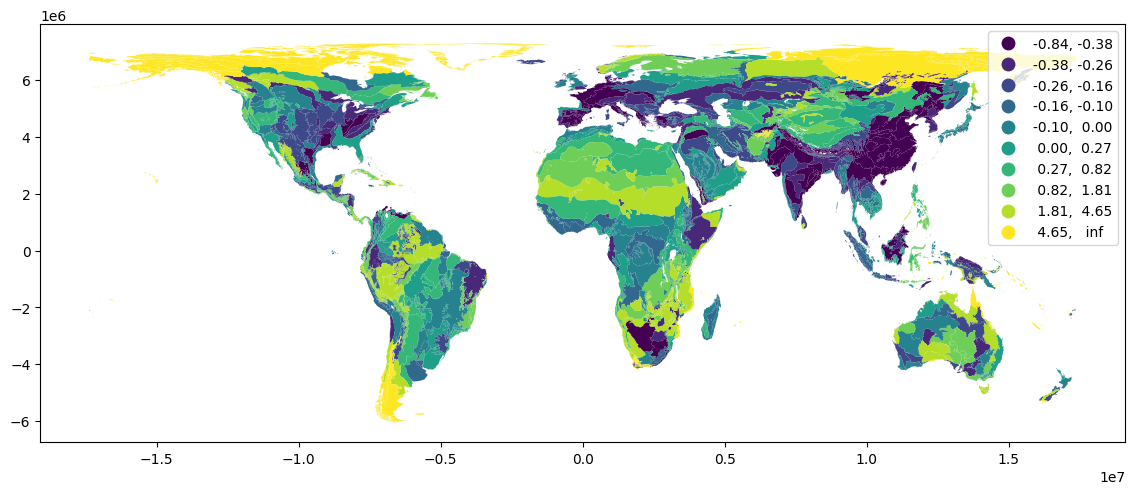

In [ ]:
SO2_eq_th.plot(column="TB_distance", legend = True, figsize = (14,8), scheme="Quantiles", k = 10, cmap="coolwarm")

c:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\.venv\Lib\site-packages\mapclassify\classifiers.py:942: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
c:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\.venv\Lib\site-packages\mapclassify\classifiers.py:972: RuntimeWarning: invalid value encountered in scalar divide
  gadf = 1 if adam == 0 else 1 - self.adcm / adam


<Axes: >

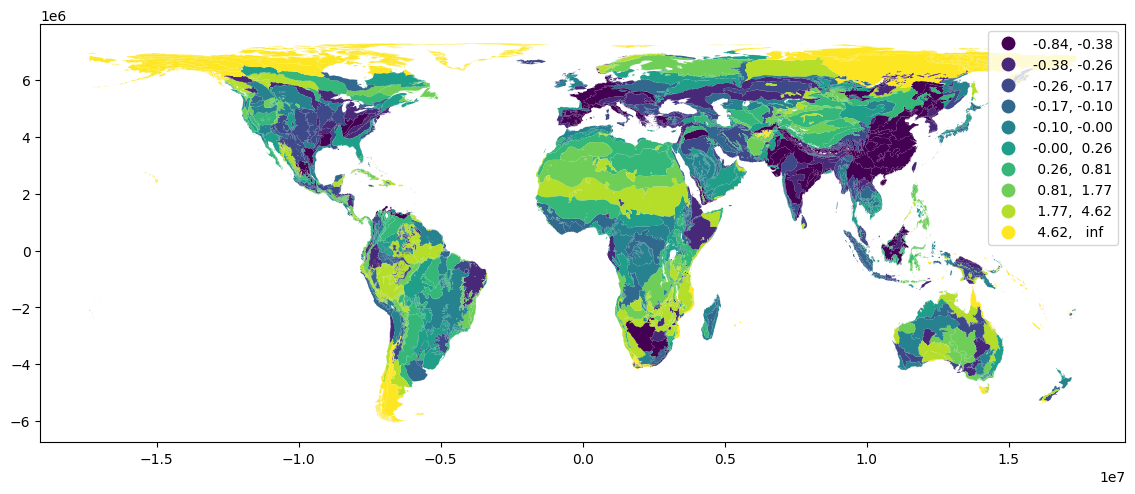

In [ ]:
SO2_eq_th.plot(column="TB_distance_SO2", legend = True, figsize = (14,8), scheme="Quantiles", k = 10, cmap="coolwarm")

<Axes: >

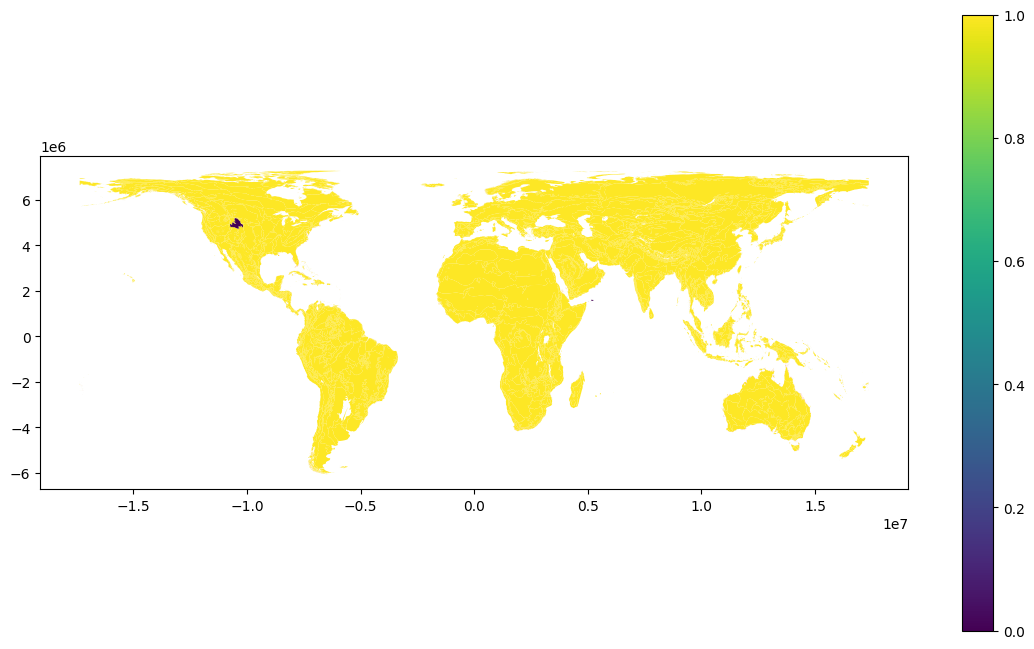

In [131]:
SO2_eq_th.plot(column="TBD_ratio", legend = True, figsize = (14,8))

So it looks like all ecoregions are ok except one. Checking which one...

In [185]:
missing_data = SO2_eq_th[SO2_eq_th["TBD_ratio"].round(2)!=1]

So there are 9 ecoregions that don't have the proper information. From this there are 2 with baselines of 0 depositions, 3 have the exact same baseline and target, while the rest lack depositions breakdown information. The latter are the only ones that need further work. Selecting them

In [186]:
missing_er_data = missing_data[missing_data["TB_distance_SO2"].isna()]

For this, the breakdown will be assigned based on the biome average

In [187]:
data_to_average = SO2_eq_th[SO2_eq_th["BIOME_NAME"].isin(missing_er_data["BIOME_NAME"])].copy().dropna(subset=["NHx_avg", "NOy_avg", "BIOME_NUM"])
data_to_average["area_m2"] = data_to_average.geometry.area

In [188]:
data_to_average.head(2)

,OBJECTID,ECO_NAME,BIOME_NUM,BIOME_NAME,REALM,ECO_BIOME_,ECO_ID,geometry,imp_cat,unit,...,N_th_so2,er_base_NHx,er_base_NOy,er_base_NHx_so2,er_base_NOy_so2,er_base_N_so2,TB_distance,TB_distance_SO2,TBD_ratio,area_m2
0,2.0,Admiralty Islands lowland rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,135,"MULTIPOLYGON (((14211289.839 -328506.485, 1420...",N depositions,kg N/ha,...,1.657092,0.708381,0.49162,0.071725,0.027701,0.099426,13.999999,13.999999,1.0,2.098541e+09
1,3.0,Aegean and Western Turkey sclerophyllous and m...,12.0,"Mediterranean Forests, Woodlands & Scrub",Palearctic,PA12,785,"MULTIPOLYGON (((2594187.496 4232365.534, 25938...",N depositions,kg N/ha,...,11.645497,5.855720,4.14428,9.524908,6.002421,15.527329,-0.325000,-0.325000,1.0,1.335579e+11


In [189]:
perc_biome_avg = (
    data_to_average
    .groupby("BIOME_NUM")
    .apply(
        lambda df: pd.Series({
            "NHx_perc": (df["NHx_perc"] * df["area_m2"]).sum() / df["area_m2"].sum(),
            "NOy_perc": (df["NOy_perc"] * df["area_m2"]).sum() / df["area_m2"].sum()
        }),
        include_groups=False 
    )
    .reset_index()
)

In [190]:
perc_biome_avg

,BIOME_NUM,NHx_perc,NOy_perc
0,1.0,0.609926,0.390074
1,12.0,0.603708,0.396292
2,13.0,0.490621,0.509379


So now adding them back to the original dataframe

In [195]:
SO2_eq_th = SO2_eq_th.merge(perc_biome_avg, on="BIOME_NUM", how="left")

In [196]:
SO2_eq_th["NHx_perc_x"] = SO2_eq_th["NHx_perc_x"].fillna(SO2_eq_th["NHx_perc_y"])
SO2_eq_th["NOy_perc_x"] = SO2_eq_th["NOy_perc_x"].fillna(SO2_eq_th["NOy_perc_y"])

In [197]:
SO2_eq_th = SO2_eq_th.drop(columns=["NHx_perc_y", "NOy_perc_y"]).rename(columns={"NHx_perc_x": "NHx_perc", "NOy_perc_x": "NOy_perc"})

And finally recalculating all needed columns

In [198]:
# Thresholds
SO2_eq_th["NHx_th_so2"] = SO2_eq_th["NHx_th"] *  SO2_eq_th["leaf_nh3"] * n2nh3
SO2_eq_th["NOy_th_so2"] = SO2_eq_th["NOy_th"] *  SO2_eq_th["leaf_nox"] * n2no2
SO2_eq_th["N_th_so2"] = SO2_eq_th["NHx_th_so2"] + SO2_eq_th["NOy_th_so2"]

# Baselines
SO2_eq_th["er_base_NHx"] = SO2_eq_th["Ecoregion baseline"] *  SO2_eq_th["NHx_perc"]
SO2_eq_th["er_base_NOy"] = SO2_eq_th["Ecoregion baseline"] *  SO2_eq_th["NOy_perc"]

# Converted Baselines
SO2_eq_th["er_base_NHx_so2"] = SO2_eq_th["er_base_NHx"] *  SO2_eq_th["leaf_nh3"] * n2nh3
SO2_eq_th["er_base_NOy_so2"] = SO2_eq_th["er_base_NOy"] *  SO2_eq_th["leaf_nox"] * n2no2
SO2_eq_th["er_base_N_so2"] = SO2_eq_th["er_base_NHx_so2"] + SO2_eq_th["er_base_NOy_so2"]

# Calculating percentages over target
SO2_eq_th["TB_distance"] = (SO2_eq_th["Threshold"]*0.9 - SO2_eq_th["Ecoregion baseline"])/SO2_eq_th["Ecoregion baseline"]
SO2_eq_th["TB_distance_SO2"] = (SO2_eq_th["N_th_so2"]*0.9 - SO2_eq_th["er_base_N_so2"] )/SO2_eq_th["er_base_N_so2"] 
SO2_eq_th["TBD_ratio"] = SO2_eq_th["TB_distance"]/SO2_eq_th["TB_distance_SO2"]


And plotting

c:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\.venv\Lib\site-packages\mapclassify\classifiers.py:942: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
c:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\.venv\Lib\site-packages\mapclassify\classifiers.py:972: RuntimeWarning: invalid value encountered in scalar divide
  gadf = 1 if adam == 0 else 1 - self.adcm / adam


<Axes: >

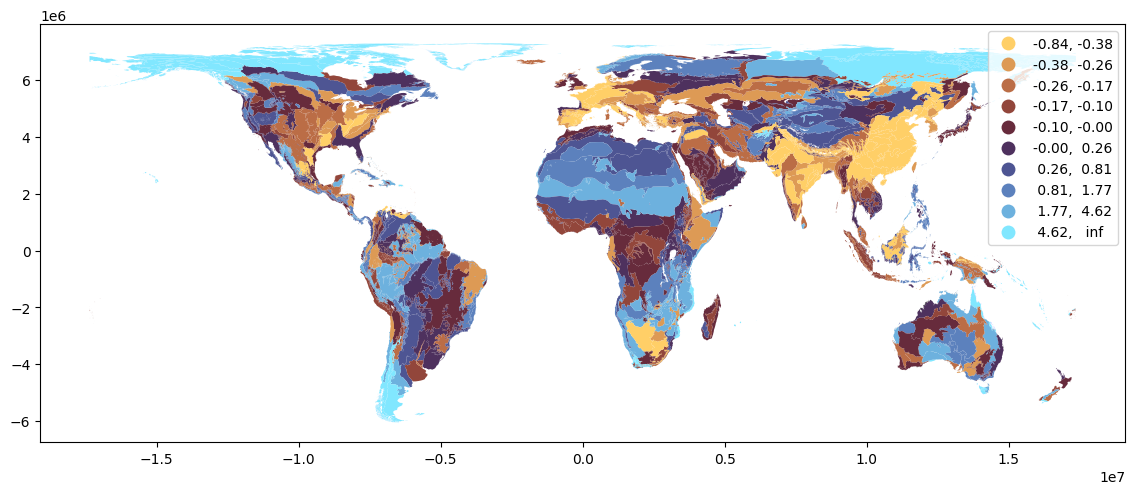

In [207]:
SO2_eq_th.plot(column="TB_distance_SO2", legend = True, figsize = (14,8), scheme="Quantiles", k = 10, cmap="managua")

## Exporting

Finally, exporting the translated thresholds

In [202]:
SO2_eq_th.columns

Index(['OBJECTID', 'ECO_NAME', 'BIOME_NUM', 'BIOME_NAME', 'REALM',
       'ECO_BIOME_', 'ECO_ID', 'geometry', 'imp_cat', 'unit', 'N_avg', 'N_med',
       'N_std', 'NHx_avg', 'NHx_med', 'NHx_std', 'NOy_avg', 'NOy_med',
       'NOy_std', 'NHx_perc', 'NOy_perc', 'Threshold', 'Ecoregion baseline',
       'NHx_th', 'NOy_th', 'leaf_nh3', 'leaf_nox', 'leaf_so2', 'NHx_th_so2',
       'NOy_th_so2', 'N_th_so2', 'er_base_NHx', 'er_base_NOy',
       'er_base_NHx_so2', 'er_base_NOy_so2', 'er_base_N_so2', 'TB_distance',
       'TB_distance_SO2', 'TBD_ratio'],
      dtype='object')

In [204]:
SO2_eq_th_toexport = SO2_eq_th[["ECO_ID", "ECO_NAME", 'Threshold', 'Ecoregion baseline', "er_base_N_so2", 'N_th_so2', 'NHx_perc', 'NOy_perc', 'leaf_nh3', 'leaf_nox', 'leaf_so2']]

In [205]:
SO2_eq_th_toexport.to_csv("../thresholds/acid_tresholds_so2.csv", sep=";")